# 1D Wavelength Calibration Tutorial 2: Multiple Arc Spectra

This notebook demonstrates the use of several arc spectra and a custom line list in calculating the wavelength solution. We use three arc spectra taken with the R1000R grism from the [Gran Telescopio Canaria's](https://www.gtc.iac.es/) [Osiris spectrograph](https://www.gtc.iac.es/instruments/osiris/).

In [37]:
import astropy.units as u
import numpy as np

from astropy.table import Table
from astropy.nddata import StdDevUncertainty
from matplotlib.pyplot import setp, subplots, close, rc

from specreduce.compat import Spectrum
from specreduce.wavecal1d import WavelengthCalibration1D

rc('figure', figsize=(11, 3))

## 1.  Read in the Arc Spectra and Initialize the Wavelength Solution Class

We use a custom line list for the HgAr arc spectrum. The values are taken from the [official GTC Osiris line list](https://www.gtc.iac.es/instruments/osiris/media/lines/GTClinelist0.txt).

In [38]:
lamps = 'HgAr', 'Ne', 'Xe'

tb = Table.read('osiris_arcs.fits')
arc_spectra = [Spectrum(tb[f'{l}_flux'].value.astype('d')*u.DN, 
                        uncertainty=StdDevUncertainty(tb[f'{l}_err'].value.astype('d'))) 
               for l in lamps]

In [39]:
hgar = np.array([5460.735, 5769.598, 5790.663,  6965.431, 7272.936, 7635.106, 7724.207, 7948.176, 8115.311, 8264.522, 9122.967])

ws = WavelengthCalibration1D(ref_pixel=1000, degree=4, arc_spectra=arc_spectra,
                             line_lists=[hgar, ['NeI'], ['XeI']],
                             line_list_bounds=(5100, 10000), unit=u.angstrom, wave_air=True)

ws.find_lines(fwhm=4, noise_factor=15)

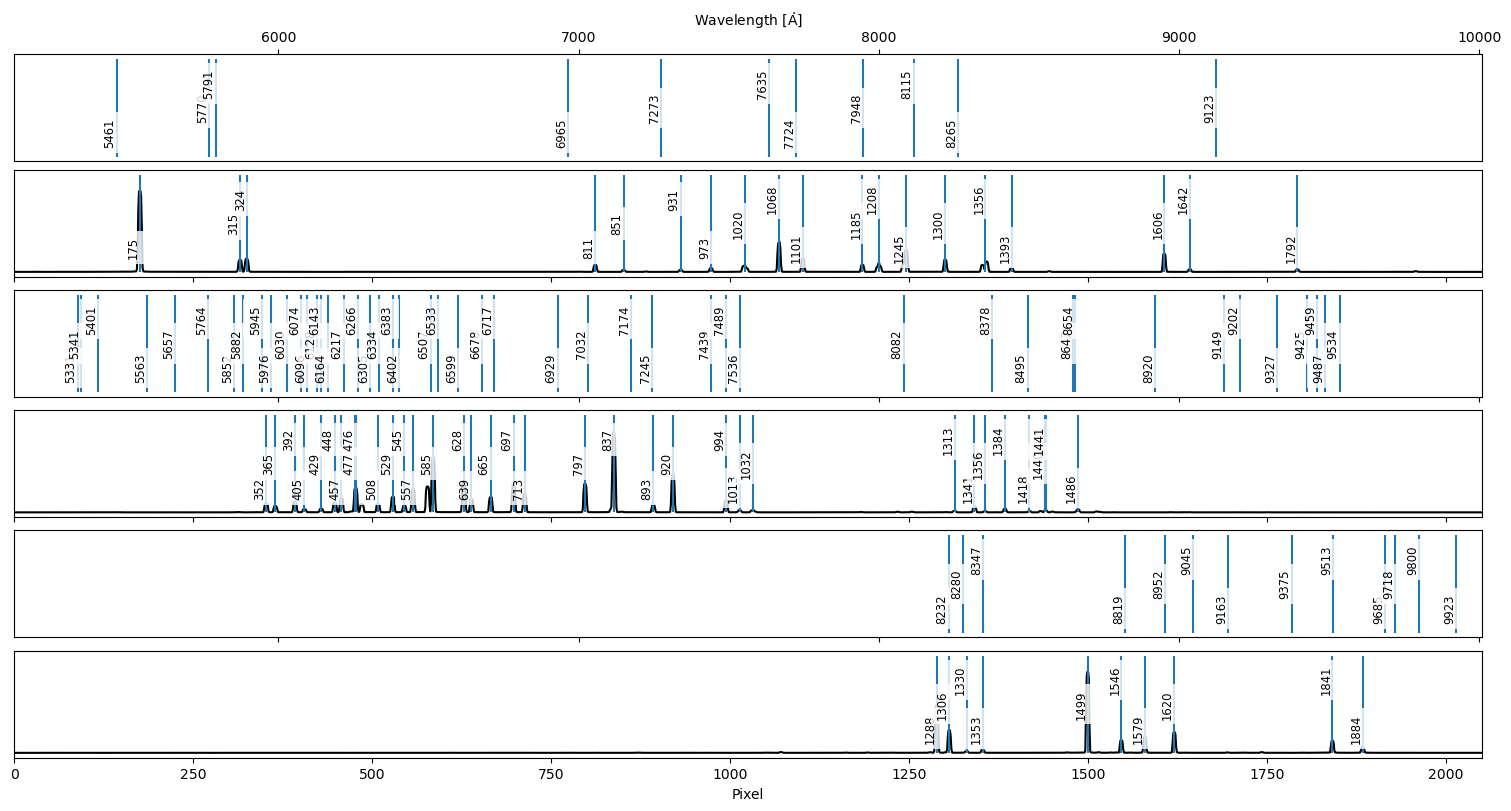

In [40]:
ws.plot_fit(figsize=(15, 8));

## 5. Fit an Initial Solution Manually

In [41]:
ws.fit_lines(pixels=[175, 797, 1499, 1579, 1620], wavelengths=[5461, 6931, 8822, 9048, 9165], match_obs=True, match_cat=True)

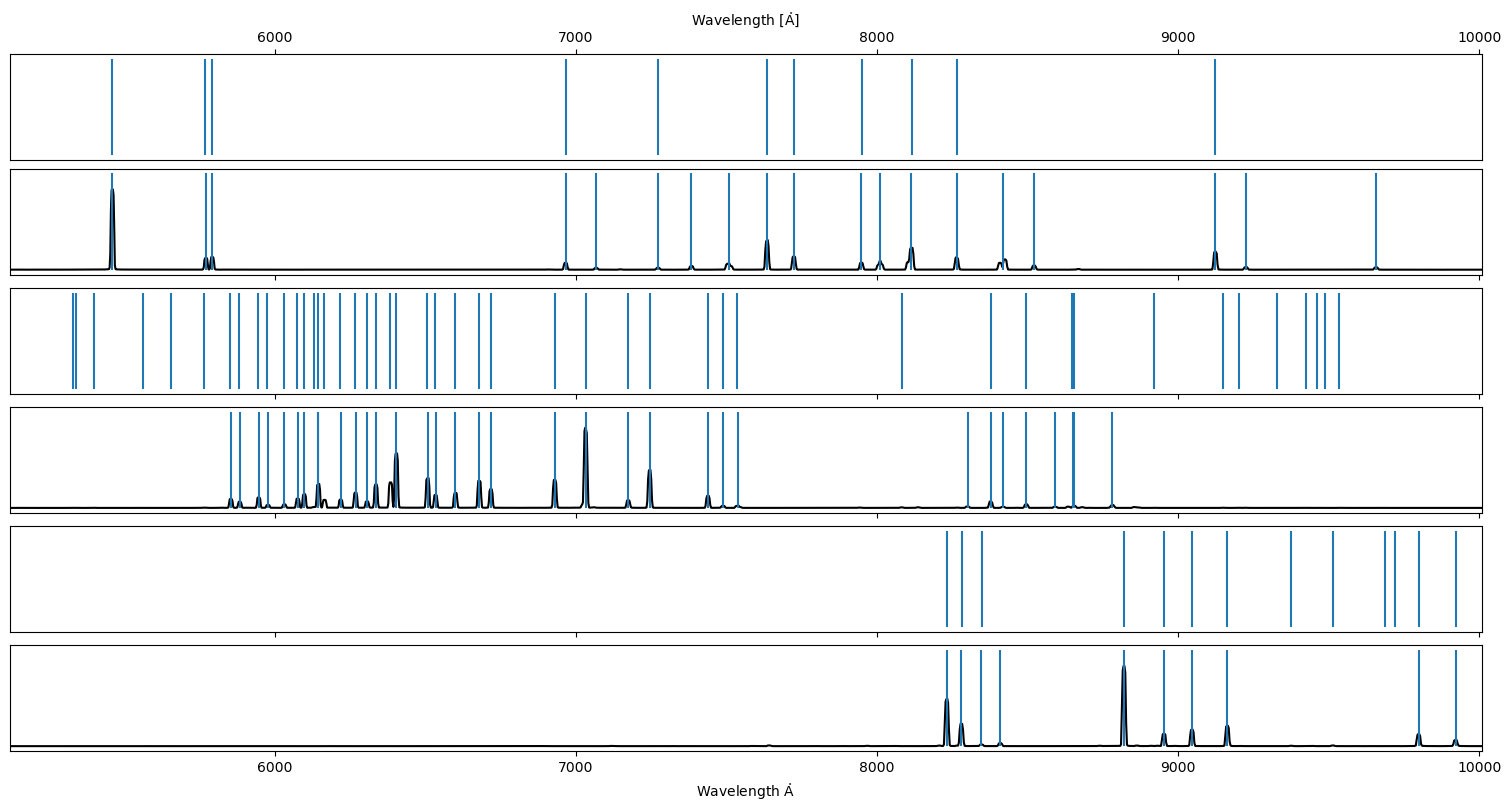

In [42]:
ws.plot_fit(figsize=(15, 8), plot_values=False, obs_to_wav=True);

## 6. Evaluate the Initial Fit: Plot Residuals

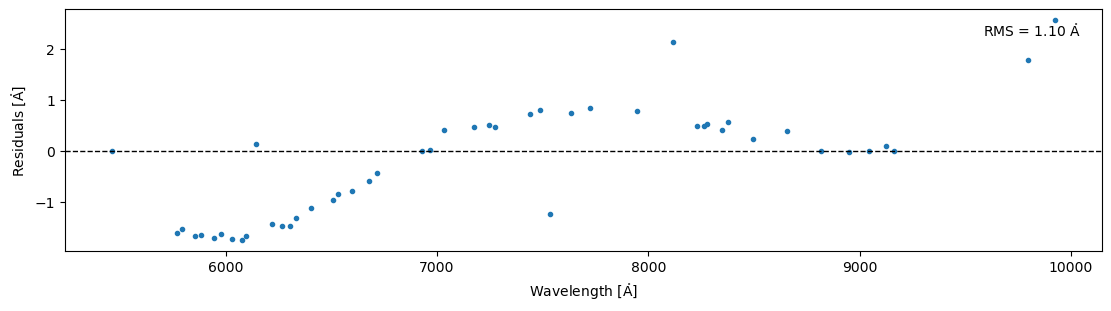

In [43]:
ws.plot_residuals(space='wavelength');

## 7. Refine the Fit

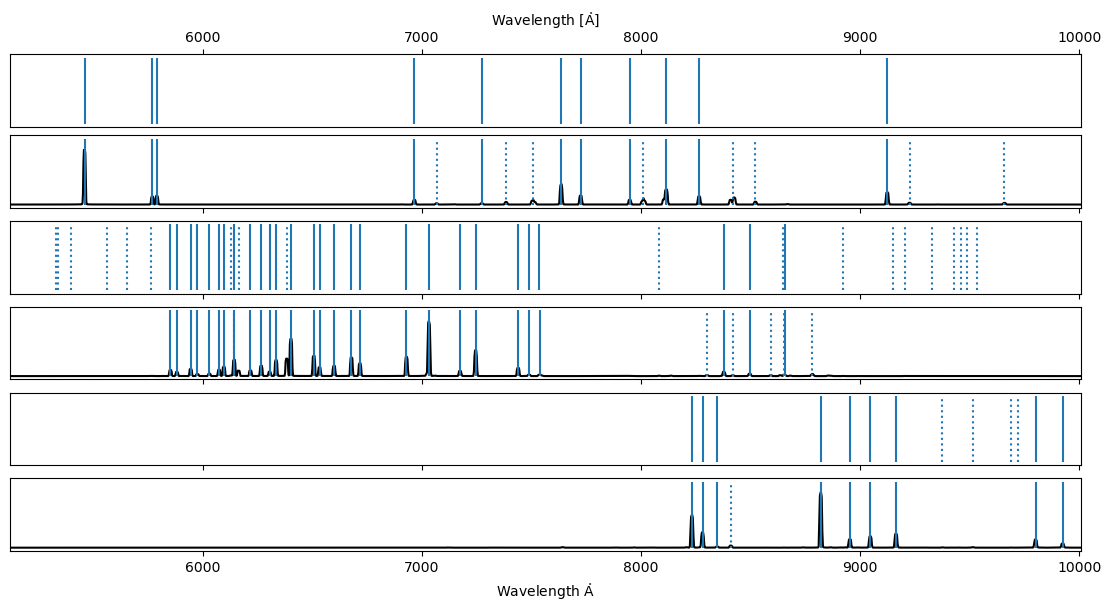

In [44]:
ws.refine_fit(match_distance_bound=25)
ws.plot_fit(figsize=(11,6), plot_values=False, obs_to_wav=True);

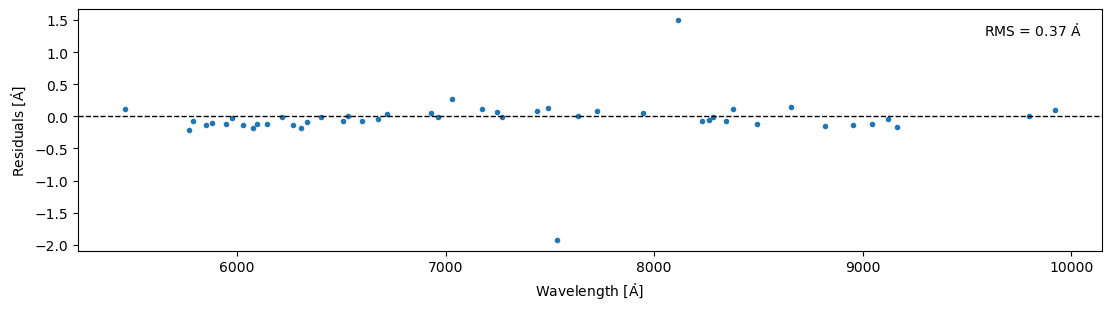

In [45]:
ws.plot_residuals(space='wavelength');

### 8. Rebin a Spectrum to Wavelength Space

A primary goal of wavelength calibration is to transform spectra from the detector's pixel grid to a physical wavelength grid. The `resample` method does this, converting a `Spectrum1D` object from pixel space to wavelength space.

Key parameters for `resample`:
- `spectrum`: The input `Spectrum` object (assumed to be on a pixel grid corresponding to the calibration).
- `nbins`: (int, optional) The number of bins desired in the output wavelength grid. If `None`, defaults to the number of pixels in the input spectrum.
- `wlbounds`: (tuple[float, float], optional) The desired `(start_wavelength, end_wavelength)` for the output grid. If `None`, defaults to the wavelengths corresponding to the first and last pixels.
- `bin_edges`: (Sequence[float], optional) Explicitly define the wavelength edges of the output bins. If provided, `nbins` and `wlbounds` are ignored.

The method uses the fitted `_p2w`, `_w2p`, and `_p2w_dldx` transformations to map the input pixel bins to the output wavelength bins. It performs an exact flux-conserving rebinning, meaning the total flux in the output spectrum matches the total flux in the input spectrum (adjusted for the units transformation from counts/pixel to counts/wavelength_bin).

Here, we demonstrate by resampling the original arc spectrum itself. In a typical workflow, you would apply this `resample` method (using the `ws` object derived from the arc lamp) to your *science* spectrum observed with the same instrument setup.

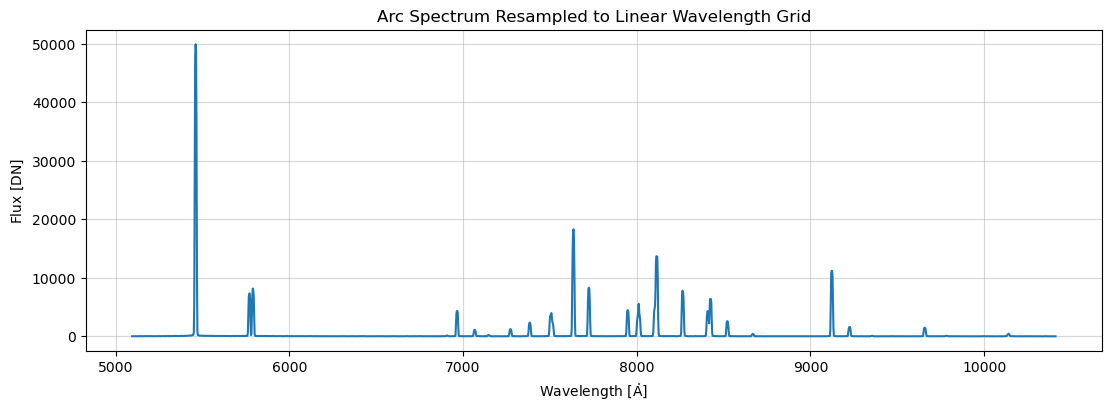

In [33]:
spectrum_wl = ws.resample(arc_spectra[0])

fig, ax = subplots(constrained_layout=True, figsize=(11, 4))
ax.plot(spectrum_wl.spectral_axis, spectrum_wl.flux)
ax.set_xlabel(f"Wavelength [{spectrum_wl.spectral_axis.unit.to_string('latex')}]")
ax.set_ylabel(f"Flux [{spectrum_wl.flux.unit.to_string('latex')}]")
ax.set_title("Arc Spectrum Resampled to Linear Wavelength Grid")
ax.grid(True, alpha=0.5)

Additionally, if we don't want to rebin, or maybe want to do it using another method, we can access the pixel-wavelength transform as a [gwcs](https://gwcs.readthedocs.io/) WCS object usin the `WCS` property.

In [34]:
ws.wcs

<WCS(output_frame=SpectralFrame, input_frame=CoordinateFrame, forward_transform=Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] | [1]
Components: 
    [0]: <Shift(offset=-1000.)>

    [1]: <Polynomial1D(4, c0=7454.4157509, c1=2.63556189, c2=0.0002202, c3=-0.00000005, c4=0.)>
Parameters:
    offset_0       c0_1       ...          c3_1                   c4_1        
    -------- ---------------- ... ---------------------- ---------------------
     -1000.0 7454.41575090495 ... -5.006614108686105e-08 4.212537047788065e-12)>

In [35]:
ws.wcs.pixel_to_world([100, 101])

<SpectralCoord [5300.03164712, 5302.13728579] Angstrom>

---